In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.linear_model import LogisticRegression


from scipy.cluster.hierarchy import dendrogram

from sklearn.feature_selection import mutual_info_classif, chi2, f_classif
import warnings
warnings.filterwarnings('ignore')

from statsmodels.stats.multitest import fdrcorrection


In [3]:
df = pd.read_csv("Breast_GSE45827.csv")


## EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Columns: 54677 entries, samples to AFFX-TrpnX-M_at
dtypes: float64(54675), int64(1), object(1)
memory usage: 63.0+ MB


In [5]:
df.head(5)

,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,84,basal,9.850040,8.097927,6.424728,7.353027,3.029122,6.880079,4.963740,4.408328,...,12.229711,11.852955,13.658701,13.477698,6.265781,5.016196,4.901594,2.966657,3.508495,3.301999
1,85,basal,9.861357,8.212222,7.062593,7.685578,3.149468,7.542283,5.129607,4.584418,...,12.178531,11.809408,13.750086,13.470146,6.771853,5.291005,5.405839,2.934763,3.687666,3.064299
2,87,basal,10.103478,8.936137,5.735970,7.687822,3.125931,6.562369,4.813449,4.425195,...,12.125108,11.725766,13.621732,13.295080,6.346952,5.171403,5.184286,2.847684,3.550597,3.158535
3,90,basal,9.756875,7.357148,6.479183,6.986624,3.181638,7.802344,5.490982,4.567956,...,12.111235,11.719215,13.743108,13.508861,6.610284,5.193356,5.086569,3.031602,3.524981,3.272665
4,91,basal,9.408330,7.746404,6.693980,7.333426,3.169923,7.610457,5.372469,4.424426,...,12.173642,11.861296,13.797774,13.542206,6.414354,5.040202,5.235318,2.956232,3.445501,3.193947


In [6]:
df.notnull().count()

samples            151
type               151
1007_s_at          151
1053_at            151
117_at             151
                  ... 
AFFX-ThrX-5_at     151
AFFX-ThrX-M_at     151
AFFX-TrpnX-3_at    151
AFFX-TrpnX-5_at    151
AFFX-TrpnX-M_at    151
Length: 54677, dtype: int64

In [7]:
df.notnull().count().min(), df.notnull().count().max()

(151, 151)

In [8]:
genes_matrix = df.drop(["samples", "type"], axis=1).values
genes_names = df.columns[2:]




color_map = {
    "normal": "#2ca02c",  # Olive green, good for 'normal' to symbolize health
    "HER": "#1f77b4",    # Mutated blue, a stark contrast for highlighting HER
    "luminal_B": "#9467bd",  # Soft purple, distinct yet clearly differentiable
    "luminal_A": "#8c564b",  # Rosy brown, subtle and distinct from luminal_B
    "cell_line": "#ff7f0e",  # Bright orange, stands out for 'cell line'
    "basal": "#d62728"     # Strong red, impactful for highlighting 'basal'
}


cancer_labels = df["type"].values
type_encoder = { t: i for i, t in enumerate(color_map.keys())}

labels = [type_encoder[t] for t in cancer_labels]



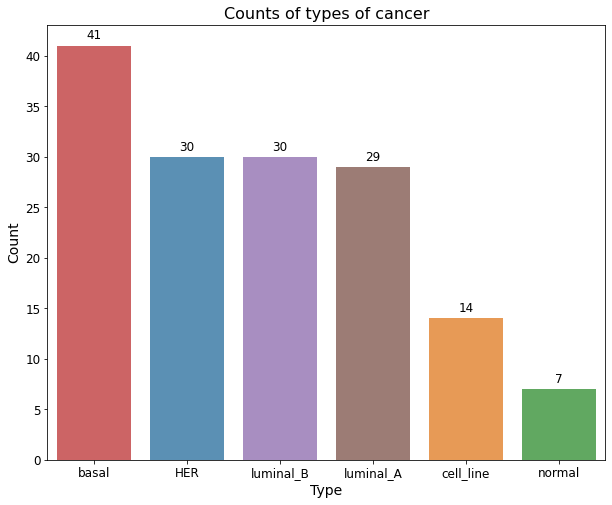

In [9]:
plt.figure(figsize=(10, 8))

value_counts = df["type"].value_counts().reset_index()
value_counts.columns = ['type', 'count']


ax = sns.barplot(x='type', y='count', data=value_counts, palette=color_map, hue="type", alpha=0.8)
ax.set_title('Counts of types of cancer', fontsize=16)
ax.set_xlabel('Type', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.tick_params(labelsize=12)
plt.xticks(rotation=0)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize=12)


plt.show()


In [10]:
print("Min value of gene expression is ", genes_matrix.min())
print("Max value of gene expression is ", genes_matrix.max())
print("Total variance in gene matrix is ", genes_matrix.var())

Min value of gene expression is  2.17109972663613
Max value of gene expression is  14.9701002149474
Total variance in gene matrix is  4.526885278734545


## PCA


In [11]:
%%time

#using PCA to see how many companents we need to achieve good explained variance

pca = PCA(n_components=100)
pca.fit(genes_matrix)

CPU times: user 8.57 s, sys: 5.27 s, total: 13.8 s
Wall time: 3.87 s


PCA(n_components=100)

In [12]:
%%time 

genes_matrix_pca = pca.transform(genes_matrix)

CPU times: user 356 ms, sys: 42.7 ms, total: 399 ms
Wall time: 152 ms


In [13]:
genes_matrix_pca.shape

(151, 100)

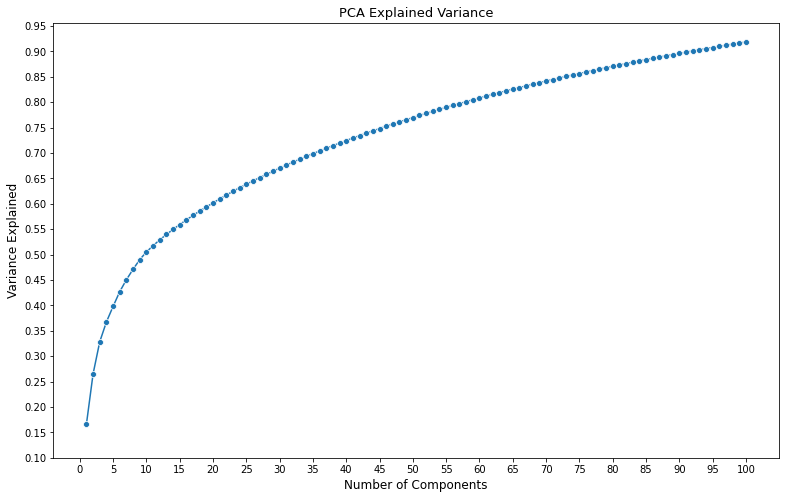

In [14]:
plt.figure(figsize=(13, 8))
sns.lineplot(x=np.arange(1, pca.n_components_ + 1, 1), y=np.cumsum(pca.explained_variance_ratio_), marker="o")
plt.title('PCA Explained Variance', fontsize=13)
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Variance Explained', fontsize=12)
plt.xticks(np.arange(0, 105, 5))
plt.yticks(np.arange(0.1, 1, 0.05))
plt.show()

In [15]:
print("ratio of VAR explained by  first 100 PCs = ", np.sum(pca.explained_variance_ratio_))

ratio of VAR explained by  first 100 PCs =  0.9184403105893053


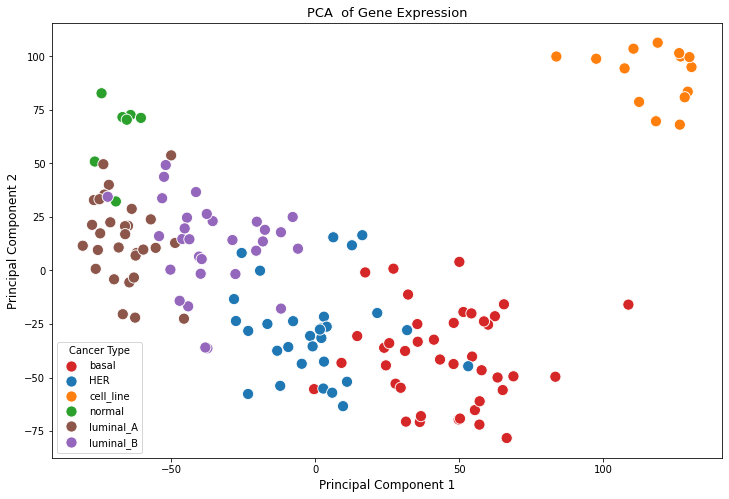

In [16]:
### let's try to visualize first 2 components from pca

pca_df = pd.DataFrame(genes_matrix_pca[:, :2], columns=['PCA1', 'PCA2'])
pca_df['Label'] = cancer_labels

plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Label', palette=color_map, s=125)

plt.title('PCA  of Gene Expression', fontsize=13)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Cancer Type')
plt.show()

## T-SNE visualization

In [17]:

tsne = TSNE(n_components=2,
            init="pca",
            learning_rate=100,
            random_state=1,
            n_jobs=-1,
            perplexity=12,
            early_exaggeration=4
            )





genes_matrix_tsne = tsne.fit_transform(genes_matrix)

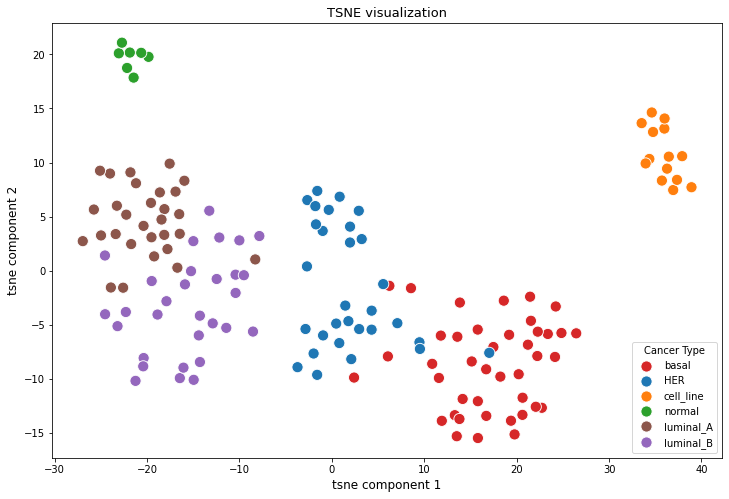

In [18]:
tsne_df = pd.DataFrame(genes_matrix_tsne[:, :2], columns=['PCA1', 'PCA2'])
tsne_df['Label'] = cancer_labels

plt.figure(figsize=(12, 8))
sns.scatterplot(data=tsne_df, x='PCA1', y='PCA2', hue='Label', palette=color_map, s=125)

plt.title('TSNE visualization', fontsize=13)
plt.xlabel('tsne component 1', fontsize=12)
plt.ylabel('tsne component 2', fontsize=12)
plt.legend(title='Cancer Type')
plt.show()

TSNE separates classes much better

## Gene selection

### Mutual Information

In [21]:
mi_df = pd.read_csv("genes_MI.csv").drop("Unnamed: 0", axis=1)
mi_df.head(5)


,gene,MI
0,211519_s_at,0.917965
1,210052_s_at,0.866330
2,202240_at,0.845233
3,218542_at,0.845002
4,202779_s_at,0.819782


In [22]:
mi_df = pd.read_csv("genes_MI.csv").drop("Unnamed: 0", axis=1)

In [24]:

mi_df = pd.DataFrame({"gene" : genes_names, 
                     "MI" : mi_scores})

mi_df = mi_df.sort_values(by="MI", ascending=False)

mi_df.to_csv("genes_MI.csv")


mi_df.head(10)

In [23]:
mi_df["MI"].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999])

0.100    0.016808
0.200    0.051215
0.300    0.078727
0.400    0.104878
0.500    0.132005
0.600    0.161793
0.700    0.197437
0.800    0.245639
0.900    0.321369
0.950    0.392730
0.990    0.539691
0.999    0.704228
Name: MI, dtype: float64

In [24]:
###a lot of features have very low MI


### Chi-Squared statistic

In [25]:
%%time 

chi2_scores, chi2_pvals = chi2(genes_matrix, labels)


##IMPORTANT STEP: pvalue adjustment
_ , chi2_pvals_adj = fdrcorrection(chi2_pvals, alpha=0.01)


chi2_df = pd.DataFrame({"gene" : genes_names, 
                     "CHI2" : chi2_scores,
                      "p_value" : chi2_pvals,
                      "p_value_adj" : chi2_pvals_adj})

chi2_df = chi2_df.sort_values(by="CHI2", ascending=False)

chi2_df.to_csv("genes_chi2.csv")


chi2_df.head(10)

CPU times: user 439 ms, sys: 263 ms, total: 702 ms
Wall time: 443 ms


,gene,CHI2,p_value,p_value_adj
37495,228241_at,214.481735,2.258643e-44,1.234913e-39
46588,237339_at,146.800900,6.402447e-30,1.750269e-25
15824,206378_at,145.705457,1.094978e-29,1.995597e-25
14672,205225_at,135.837039,1.371714e-27,1.874962e-23
18587,209173_at,128.352468,5.322940e-26,5.820635e-22
14456,205009_at,122.070630,1.143046e-24,1.041601e-20
37808,228554_at,118.543040,6.386788e-24,4.988537e-20
14491,205044_at,118.189847,7.586930e-24,5.185192e-20
33137,223861_at,116.467687,1.756418e-23,1.067024e-19
46335,237086_at,111.836230,1.676334e-22,9.165359e-19


#### TODO:
- drop all features that have both lower CHI2 and MI

## Filtering genes

In [26]:
#### selecting only features that have Mutual Information  >= 0.5

mi_selected_genes = mi_df[mi_df["MI"] >= 0.5]

mi_selected_genes

,gene,MI
0,211519_s_at,0.917965
1,210052_s_at,0.866330
2,202240_at,0.845233
3,218542_at,0.845002
4,202779_s_at,0.819782
...,...,...
853,227020_at,0.500298
854,220036_s_at,0.500290
855,1555943_at,0.500095
856,235847_at,0.500090


In [27]:
### selecting genes with chi2 pvalue  < 0.01

chi2_selected_genes  = chi2_df[chi2_df["p_value_adj"] < 0.01]
chi2_selected_genes

,gene,CHI2,p_value,p_value_adj
37495,228241_at,214.481735,2.258643e-44,1.234913e-39
46588,237339_at,146.800900,6.402447e-30,1.750269e-25
15824,206378_at,145.705457,1.094978e-29,1.995597e-25
14672,205225_at,135.837039,1.371714e-27,1.874962e-23
18587,209173_at,128.352468,5.322940e-26,5.820635e-22
...,...,...,...,...
13533,204086_at,25.252954,1.245051e-04,9.628450e-03
28777,219493_at,25.226978,1.259528e-04,9.726655e-03
28584,219300_s_at,25.209513,1.269357e-04,9.788726e-03
36883,227629_at,25.193203,1.278603e-04,9.846142e-03


In [28]:
selected_genes = list(set(list(mi_selected_genes["gene"]) + list(chi2_selected_genes["gene"])))


genes_selected_both = list(set(mi_selected_genes["gene"]) & set(chi2_selected_genes["gene"]))

print("Number of genes selected by both MI and Chi2:", len(genes_selected_both))
print("Number of genes selected by either MI or Chi2: ",len(selected_genes))

##The most valuable are probably from interesection
genes_selected_both[:10]

Number of genes selected by both MI and Chi2: 240
Number of genes selected by either MI or Chi2:  1329


['218662_s_at',
 '1555758_a_at',
 '203967_at',
 '205009_at',
 '228528_at',
 '204667_at',
 '222835_at',
 '220239_at',
 '205683_x_at',
 '210761_s_at']

### try  to visualize using only very important genes

#### PCA on selected genes

In [29]:
genes_matrix_reduced = df[genes_selected_both].values

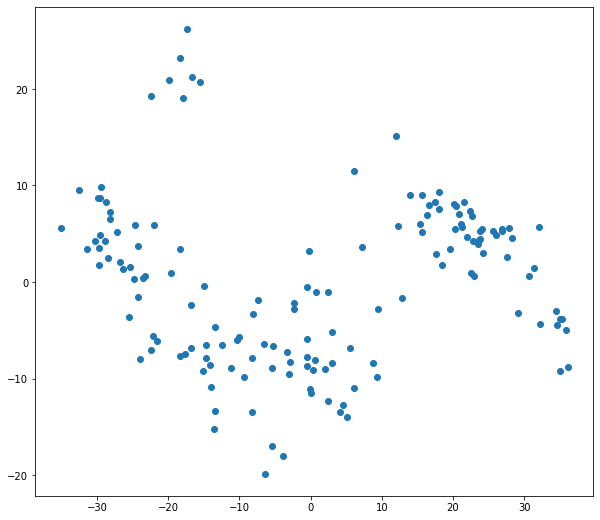

In [30]:
pca_red = PCA(n_components=2)



genes_matrix_reduced_pca = pca_red.fit_transform(genes_matrix_reduced)


plt.figure(figsize=(10, 9))
plt.scatter(genes_matrix_reduced_pca.T[0], genes_matrix_reduced_pca.T[1])

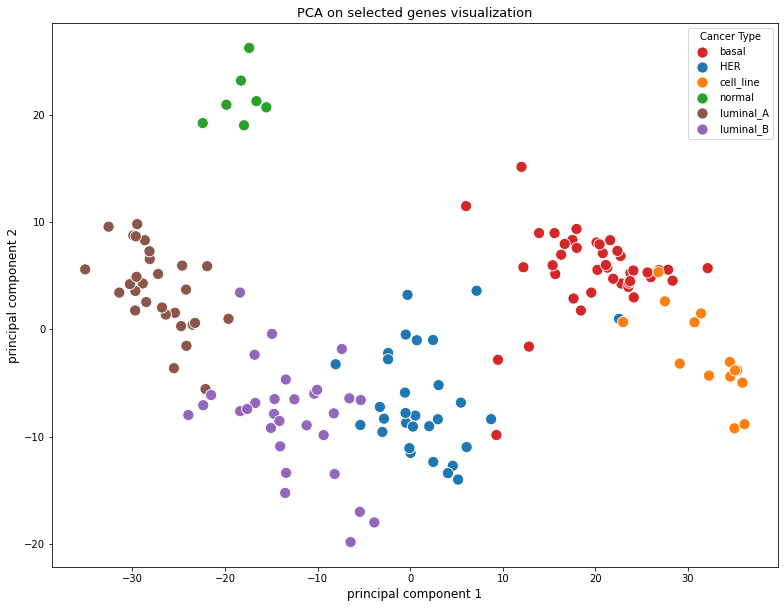

In [31]:
pca_red_df = pd.DataFrame(genes_matrix_reduced_pca[:, :2], columns=['PCA1', 'PCA2'])
pca_red_df['Label'] = cancer_labels

plt.figure(figsize=(13, 10))
sns.scatterplot(data=pca_red_df, x='PCA1', y='PCA2', hue='Label', palette=color_map, s=125)

plt.title('PCA on selected genes visualization', fontsize=13)
plt.xlabel('principal component 1', fontsize=12)
plt.ylabel('principal component 2', fontsize=12)
plt.legend(title='Cancer Type')
plt.show()

### TSNE on selected genes

In [32]:
tsne_red = TSNE(n_components=2,
            init="pca",
            learning_rate=250,
            random_state=1,
            n_jobs=-1,
            perplexity=8, 
            early_exaggeration=10
            )


genes_matrix_reduced_tsne = tsne_red.fit_transform(genes_matrix_reduced)

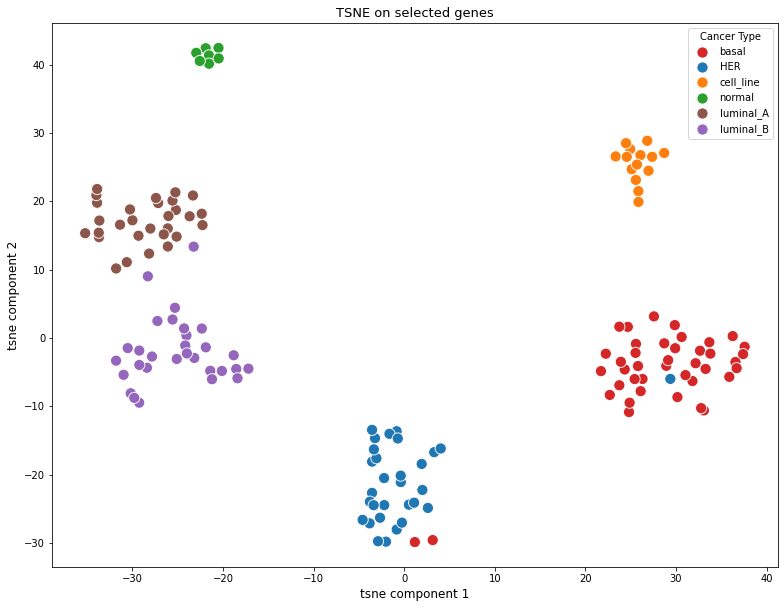

In [33]:
tsne_red_df = pd.DataFrame(genes_matrix_reduced_tsne[:, :2], columns=['tsne_component1', 'tsne_component2'])
tsne_red_df['Label'] = cancer_labels

plt.figure(figsize=(13, 10))
sns.scatterplot(data=tsne_red_df, x='tsne_component1', y='tsne_component2', hue='Label', palette=color_map, s=125)

plt.title('TSNE on selected genes', fontsize=13)
plt.xlabel('tsne component 1', fontsize=12)
plt.ylabel('tsne component 2', fontsize=12)
plt.legend(title='Cancer Type')
plt.show()

In [60]:
### We;ve got a fairly nice separation using tsne on selected genes

### TODO:
  - try clustering to identify how many clusters(types of cancers) are a good choice
  - use Logistic Regression one vs all to select genes corresponding to each type of cancer
  - come up with a set of important genes to look at for  each cancer type

### Identifying subtypes

Text(0, 0.5, 'Inertia')

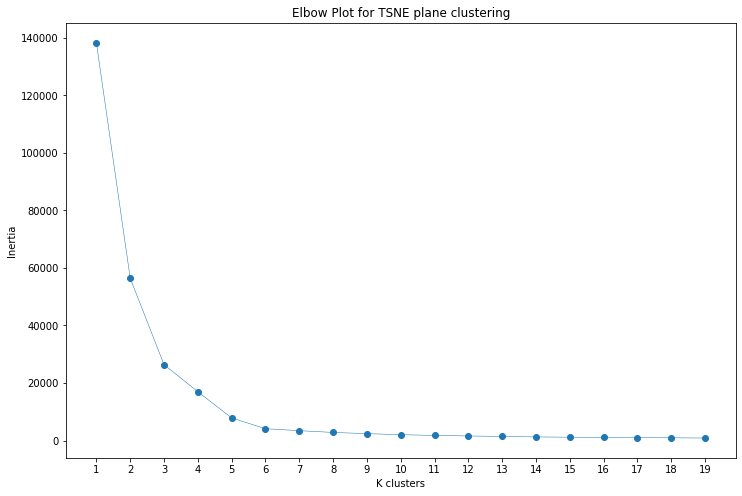

In [34]:

inertias = []

for k in range(1, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(genes_matrix_reduced_tsne)
    inertias.append(kmeans.inertia_)
    
plt.figure(figsize=(12, 8))
plt.title("Elbow Plot for TSNE plane clustering", fontsize=12)
plt.plot(np.arange(1, 20, 1), inertias, marker="o", lw=0.5)
plt.xticks(np.arange(1, 20, 1))
plt.xlabel("K clusters")
plt.ylabel("Inertia")

### Logistic Regression

In [99]:
logreg = LogisticRegression(penalty="l1",
                            solver="saga",
                            multi_class="ovr",
                            random_state=1
                            )
logreg.fit(genes_matrix_reduced, labels)

LogisticRegression(multi_class='ovr', penalty='l1', random_state=1,
                   solver='saga')

In [100]:
logreg.score(genes_matrix_reduced, labels)

0.9933774834437086

In [101]:


logreg.classes_

array([0, 1, 2, 3, 4, 5])

In [102]:
#Extract most important genes



her_coeffs = logreg.coef_[1]
lumB_coeffs = logreg.coef_[2]
lumA_coeffs = logreg.coef_[3]
cellline_coeffs = logreg.coef_[4]
basal_coeffs = logreg.coef_[5]

her_important_genes = np.argsort(np.abs(her_coeffs))[-20:]
lumB_important_genes = np.argsort(np.abs(lumB_coeffs))[-20:]
lumA_important_genes = np.argsort(np.abs(lumA_coeffs))[-20:]
cellline_important_genes = np.argsort(np.abs(cellline_coeffs))[-20:]
basal_important_genes = np.argsort(np.abs(basal_coeffs))[-20:]

her_important_gene_names = np.array(genes_selected_both)[her_important_genes]
lumB_important_gene_names = np.array(genes_selected_both)[lumB_important_genes]
lumA_important_gene_names = np.array(genes_selected_both)[lumA_important_genes]
cellline_important_gene_names = np.array(genes_selected_both)[cellline_important_genes]
basal_important_gene_names = np.array(genes_selected_both)[basal_important_genes]



In [106]:
color_map

{'normal': '#2ca02c',
 'HER': '#1f77b4',
 'luminal_B': '#9467bd',
 'luminal_A': '#8c564b',
 'cell_line': '#ff7f0e',
 'basal': '#d62728'}

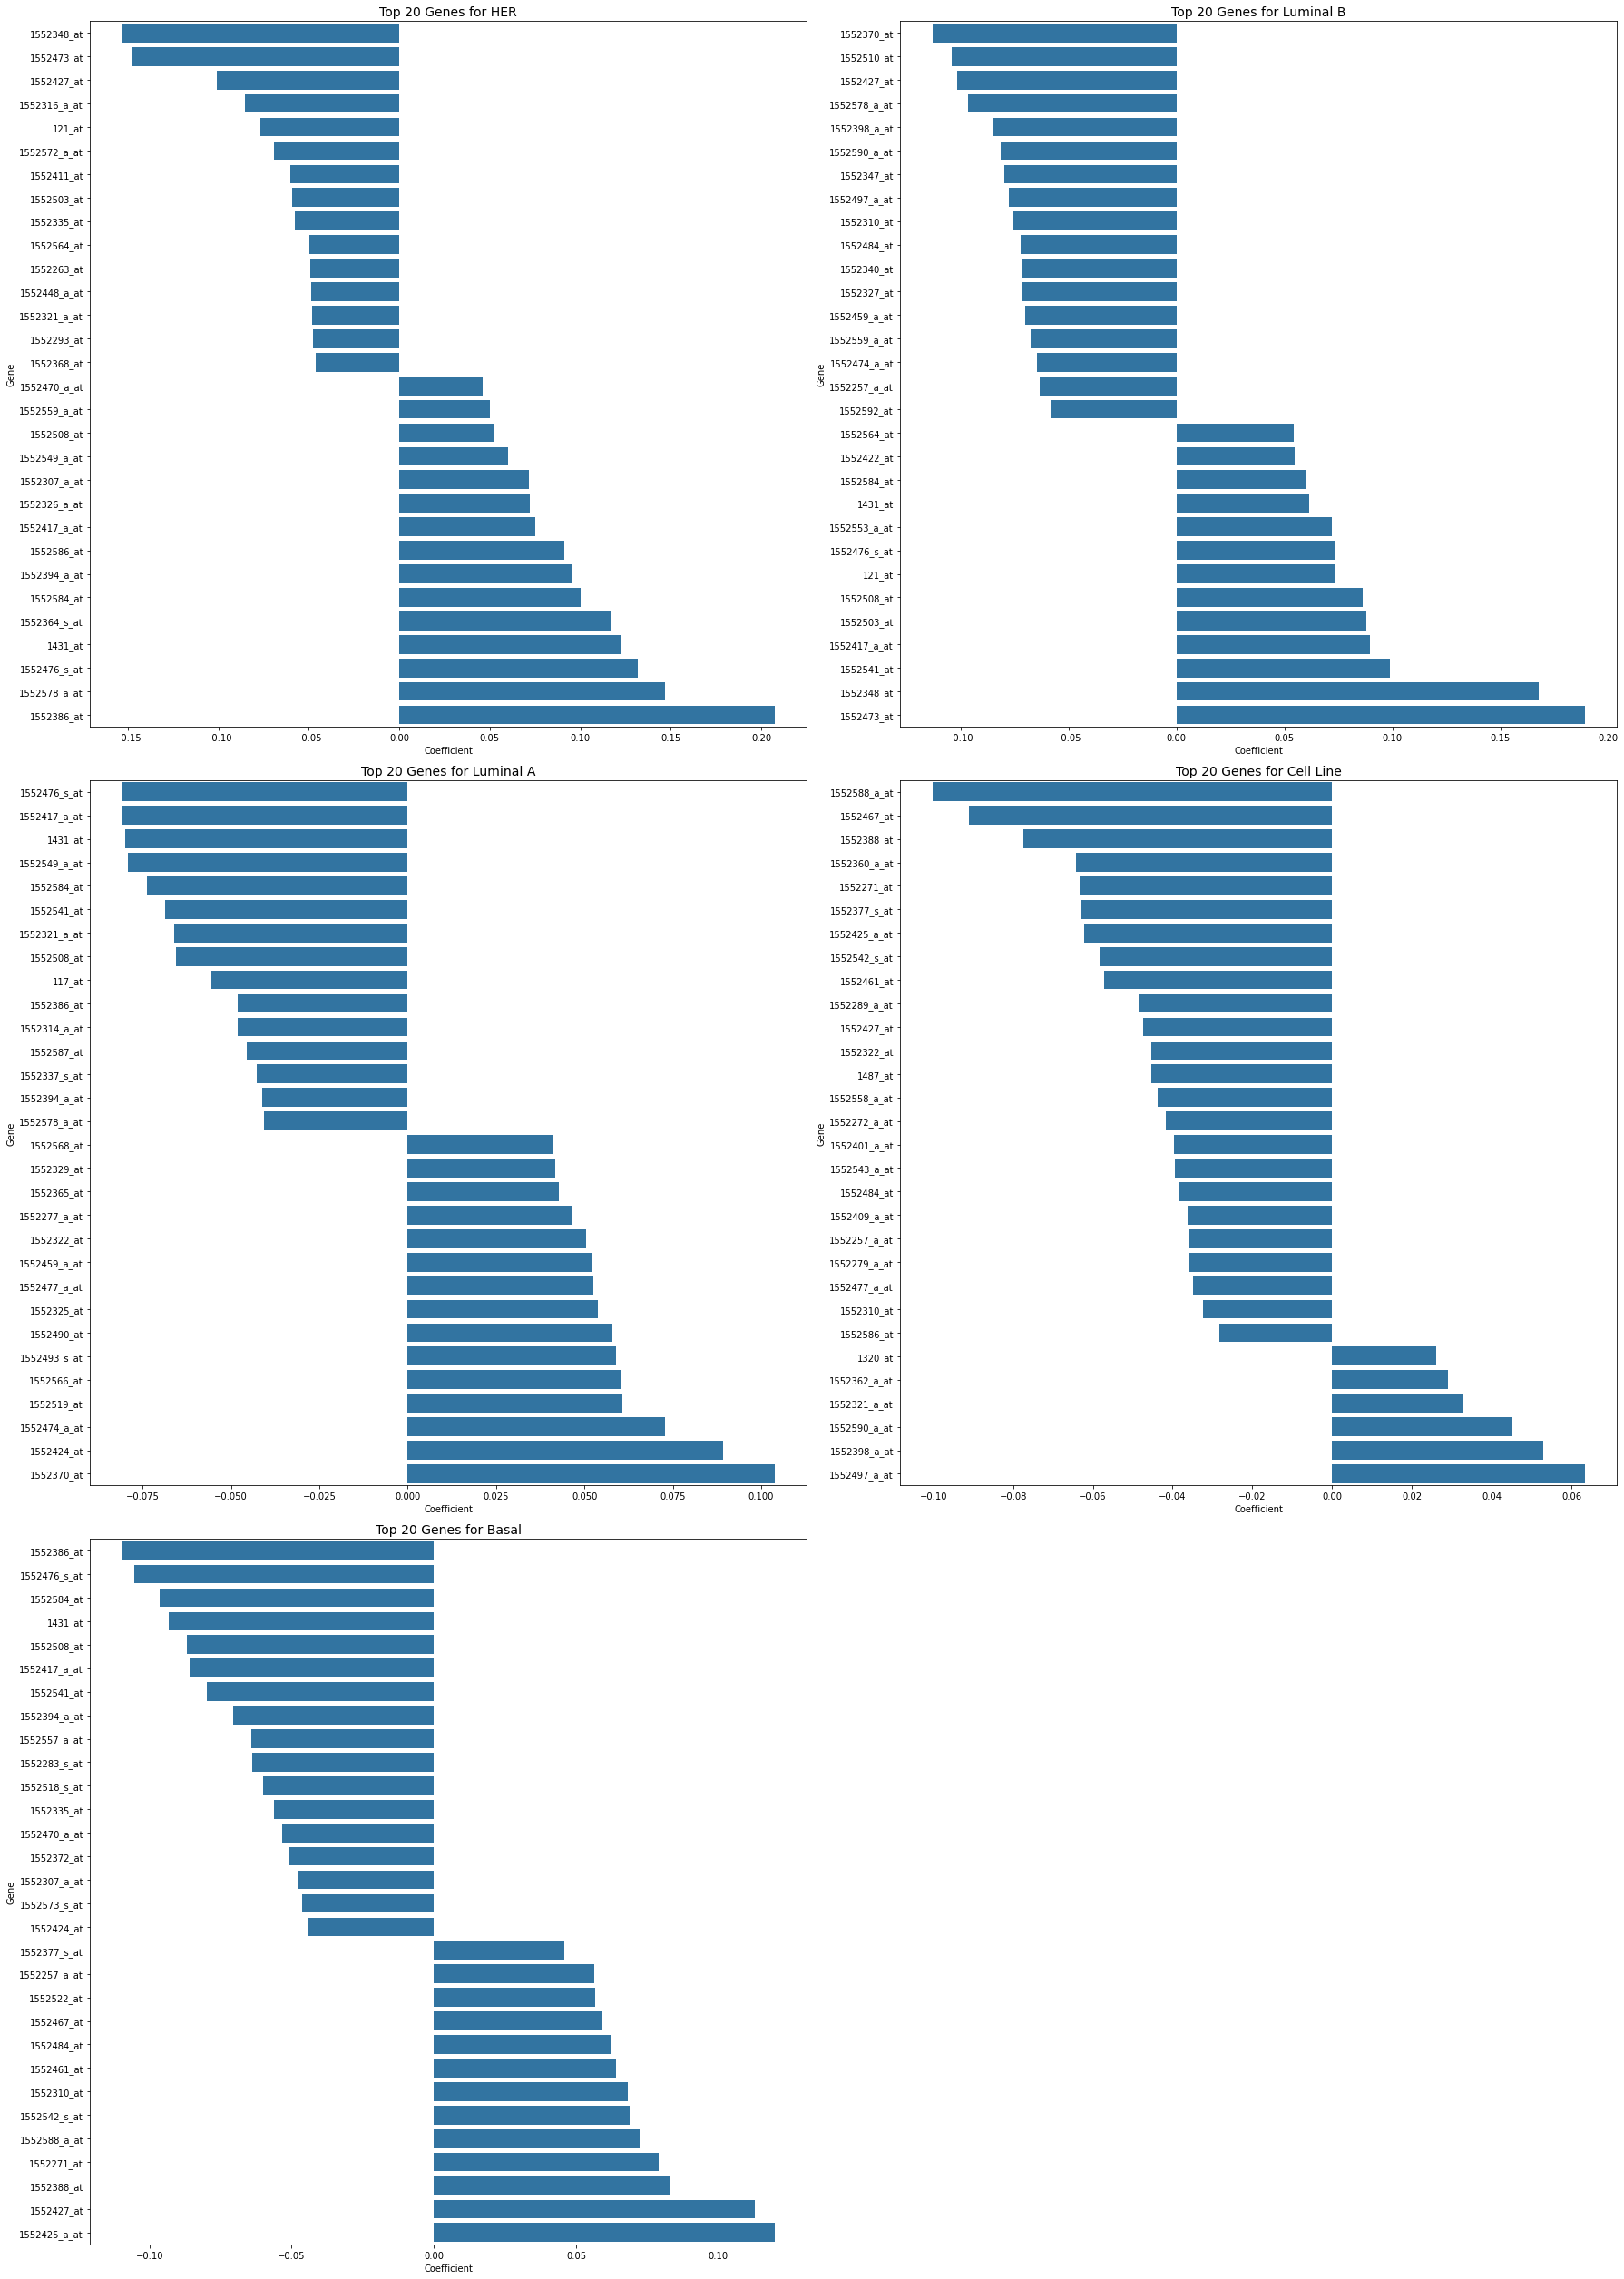

In [119]:
fig, axes = plt.subplots(3, 2, figsize=(25, 35))
categories = ['HER', 'Luminal B', 'Luminal A', 'Cell Line', 'Basal']
coefficients = [her_coeffs, lumB_coeffs, lumA_coeffs, cellline_coeffs, basal_coeffs]

for i, (coef, category) in enumerate(zip(coefficients, categories)):
    ax = axes.flat[i]
    top_indices = np.argsort(np.abs(coef))[-30:]
    data = pd.DataFrame({'Gene': genes_names[top_indices], 'Coefficient': coef[top_indices]})
    sns.barplot(x='Coefficient', y='Gene', data=data.sort_values('Coefficient', ascending=True), ax=ax)
    ax.set_title(f'Top 20 Genes for {category}', fontsize=14)

# Remove the empty subplot (if any)
for j in range(i + 1, 6):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()